<a href="https://colab.research.google.com/github/tohyongyao/AI-Project/blob/master/TYY_ANLP_GPT_2_Text_Generating_Model_w_GPU_to_generate_Taylor_Swift_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Train a GPT-2 Text-Generating Model w/ GPU to generate Taylor Swift lyrics




In [1]:
%tensorflow_version 1.x
!pip install -q gpt_2_simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



fatal: destination path 'colab_helper' already exists and is not an empty directory.


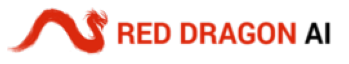

In [2]:
! git clone https://github.com/mdda/colab_helper
from colab_helper import utils as chu

import pandas as pd

## Verify GPU
 

In [3]:
!nvidia-smi

Fri Sep 18 08:29:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading GPT-2

If you're retraining a model on new text, you need to download the GPT-2 model first. 

There are two sizes of GPT-2:

* `117M` (default): the "small" model, 500MB on disk.
* `345M`: the "medium" model, 1.5GB on disk.

Larger models have more knowledge, but take longer to finetune and longer to generate text. You can specify which base model to use by changing `model_name` in the cells below.

The next cell downloads it from Google Cloud Storage and saves it in the Colaboratory VM at `/models/<model_name>`.

This model isn't permanently saved in the Colaboratory VM; you'll have to redownload it if you want to retrain it at a later time.

In [4]:
gpt2.download_gpt2(model_name="345M")

Fetching checkpoint: 1.05Mit [00:00, 340Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 63.1Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 395Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:23, 60.2Mit/s]                                 
Fetching model.ckpt.index: 1.05Mit [00:00, 205Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 31.3Mit/s]                                                
Fetching vocab.bpe: 1.05Mit [00:00, 61.2Mit/s]                                                      


## Mounting Google Drive

The best way to get input text to-be-trained into the Colaboratory VM, and to get the trained model *out* of Colaboratory, is to route it through Google Drive *first*.

Running this cell (which will only work in Colaboratory) will mount your personal Google Drive in the VM, which later cells can use to get data in/out. (it will ask for an auth code; that auth is not saved anywhere)

In [5]:
gpt2.mount_gdrive()

Mounted at /content/drive


## Download dataset from Kaggle

In [6]:
! pip install kaggle
chu.kaggle_credentials(file='./drive/My Drive/Colab Notebooks/kaggle.json')

Credentials written to /root/.kaggle/kaggle.json


In [7]:
! kaggle datasets download -d PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums

  0% 0.00/68.7k [00:00<?, ?B/s]
100% 68.7k/68.7k [00:00<00:00, 25.1MB/s]


In [8]:
!unzip taylor-swift-song-lyrics-from-all-the-albums.zip

Archive:  taylor-swift-song-lyrics-from-all-the-albums.zip
  inflating: taylor_swift_lyrics.csv  


# Preprocess the data

In [9]:
dataset = pd.read_csv('taylor_swift_lyrics.csv',encoding = "latin1")

In [10]:
# Get all lyrics
lyrics = dataset['lyric'].tolist() 

# combine and split by lines
lyrics_text = ''
for i in lyrics: 
  lyrics_text += i + '\n' 

print('Lyrics length:', len(lyrics_text))
print(lyrics_text[:50])

Lyrics length: 173604
He said the way my blue eyes shined
Put those Geor


In [11]:
text_file = open("lyrics.txt", 'w')
text_file.write(lyrics_text)
text_file.close()

In [12]:
file_name = "lyrics.txt"

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`. (to have the finetuning run indefinitely, set `steps = -1`)

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

Other optional-but-helpful parameters for `gpt2.finetune`:


*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)

In [13]:
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,
              dataset=file_name,
              model_name='345M',
              steps=1000,
              restore_from='fresh',
              print_every=10,
              sample_every=200,
              save_every=500
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Loading checkpoint models/345M/model.ckpt
INFO:tensorflow:Restoring parameters from models/345M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


dataset has 47368 tokens
Training...
[10 | 40.68] loss=1.39 avg=1.39
[20 | 70.77] loss=1.62 avg=1.50
[30 | 100.93] loss=2.02 avg=1.68
[40 | 131.16] loss=1.23 avg=1.56
[50 | 161.41] loss=1.81 avg=1.61
[60 | 191.67] loss=1.37 avg=1.57
[70 | 221.94] loss=1.33 avg=1.54
[80 | 252.14] loss=0.94 avg=1.46
[90 | 282.40] loss=0.99 avg=1.40
[100 | 312.63] loss=0.86 avg=1.35
[110 | 342.95] loss=0.95 avg=1.31
[120 | 373.27] loss=0.99 avg=1.28
[130 | 403.59] loss=1.09 avg=1.27
[140 | 433.90] loss=0.83 avg=1.23
[150 | 464.11] loss=0.76 avg=1.20
[160 | 494.42] loss=0.22 avg=1.13
[170 | 524.76] loss=0.95 avg=1.12
[180 | 555.01] loss=0.22 avg=1.07
[190 | 585.21] loss=1.02 avg=1.06
[200 | 615.45] loss=0.25 avg=1.02
======== SAMPLE 1 ========
's not easy, it takes time
Standing in the rain outside till I came out
I said, "That was incredible!"
And they'd say, "Oh, it's not your best work" and I'd look at them all and go, "What?"
I'm twenty-six now, but it still feels like
I was twenty-six years old when I

After the model is trained, you can copy the checkpoint folder to your own Google Drive.

If you want to download it to your personal computer, it's strongly recommended you copy it there first, then download from Google Drive. (NB: if you are downloading the model to your personal computer, download the large model checkpoint file *seperately*, download the other files, and reconstruct the `/checkpoint/run1` folder hierarchy locally).

In [14]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

You're done! Feel free to go to the **Generate Text From The Trained Model** section to generate text based on your retrained model.

## Load a Trained Model Checkpoint

Running the next cell will copy the `checkpoint` folder from your Google Drive into the Colaboratory VM.

In [17]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

The next cell will allow you to load the retrained model checkpoint + metadata necessary to generate text.

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

In [3]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess)

Loading checkpoint checkpoint/run1/model-1000
INFO:tensorflow:Restoring parameters from checkpoint/run1/model-1000


## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text. `generate` generates a single text from the loaded model.

In [4]:
gpt2.generate(sess, run_name='run1')

You're just a girl, right?
You're just a girl, right?
You're just a girl, right?
Just a girl, right?
Just a girl, right?
(Just a girl)
Oh, Oh, Oh, Oh, Oh, Oh, Oh, Oh
Just a girl, right?
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
She's just a girl, you know
Her name is whatever you want it to be
And her tits are as big as my bed
And her face is just as scary as mine
'Cause she's so much hotter than I am
She's so much cuter than I am
She's so much cuter than I am
I can't say anything to your face
'Cause look at her
And her body is just as beautiful as mine
And her mind is just as crazy
She's so much cuter than I am
She's so much cuter than I am
I can't say anything to your face
'Cause look at her
And